**Contents:**
- Basics - recording, loading, saving, playing audio, resampling, file info etc
- Simple operations
- Silence removal
- Augmentations - time stretch, pitch shift
- Feature extraction:
    - stft
    - melspectrogram
    - Mfcc
    - Mfcc delta features
    - tempogram
    - Fourier_tempogram
    - chroma filter bank
    - Wavelet filterbank
- Noise augmentation on feature and obtaining the signal back with griffin lim
- Additional resources


In [1]:
!pip install -U librosa==0.9.2

import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa import display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.1
    Uninstalling librosa-0.10.1:
      Successfully uninstalled librosa-0.10.1


In [2]:
librosa.__version__

'0.9.2'

Example audio files available in librosa

In [3]:
librosa.util.list_examples()

AVAILABLE EXAMPLES
--------------------------------------------------------------------
brahms    	Brahms - Hungarian Dance #5
choice    	Admiral Bob - Choice (drum+bass)
fishin    	Karissa Hobbs - Let's Go Fishin'
humpback  	Glacier Bay 60-second clip humpback whale song November 2020
libri1    	Ashiel Mystery - A Detective Story, chapter 2, narrated by Garth Comira
libri2    	The Age of Chivalry / Chapter 18: Perceval / Read by Anders Lankford
libri3    	Sense and Sensibility / Chapter 18 / Jane Austen / Read by Heather Barnett
nutcracker	Tchaikovsky - Dance of the Sugar Plum Fairy
pistachio 	The Piano Lady - Pistachio Ice Cream Ragtime
robin     	Bird Whistling, Robin, Single, 13.wav / InspectorJ
sweetwaltz	Setuniman - Sweet Waltz
trumpet   	Mihai Sorohan - Trumpet loop
vibeace   	Kevin MacLeod - Vibe Ace




---

Basics

---




load audio

In [4]:
# path = 'audio.wav'
path = librosa.example('trumpet')
y, sr = librosa.load(path)

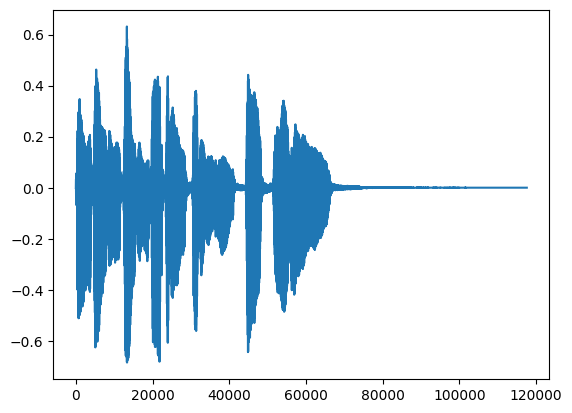

In [5]:
plt.plot(y)

record audio

In [6]:
# from https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
from IPython.display import display, Audio
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""
def record(sec, filename='audio.wav'):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec * 1000))
  b = b64decode(s.split(',')[1])
  with open(filename, 'wb+') as f:
    f.write(b)

audio = 'audio.wav'
second = 5
print(f"Speak to your microphone {second} sec...")
record(second, audio)
print("Done!")

Speak to your microphone 5 sec...


<IPython.core.display.Javascript object>

Done!


In [7]:
!soxi audio.wav

/bin/bash: line 1: soxi: command not found


In [8]:
import librosa
import librosa.display
y, sr = librosa.load(audio, sr=22050)
display(Audio(y, rate=sr))

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


plot the waveform

([<matplotlib.lines.Line2D at 0x7cc593d46c50>], 22050)

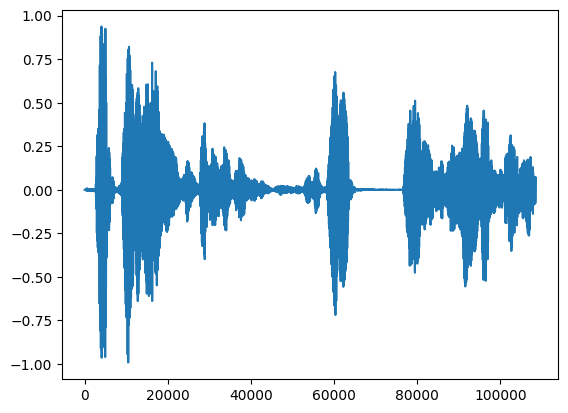

In [9]:
plt.plot(y), sr

In [10]:
Audio(y, rate=sr)

resample and load at a specific sample rate

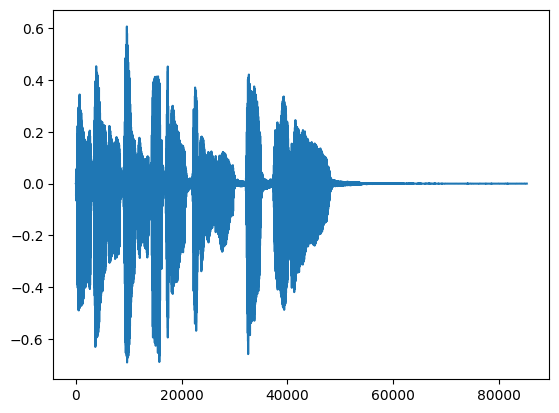

In [11]:
y, sr = librosa.load(path, sr=16000)
plt.plot(y)

In [12]:
duration = librosa.get_duration(y=y, sr=sr)
num_channels = 2 if y.shape[0] == 2 else 1
extension = path[-4:]
duration, num_channels, extension, sr, len(y)/sr

(5.3334375, 1, '.ogg', 16000, 5.3334375)



---

Simple operations

---



Half wave rectifier

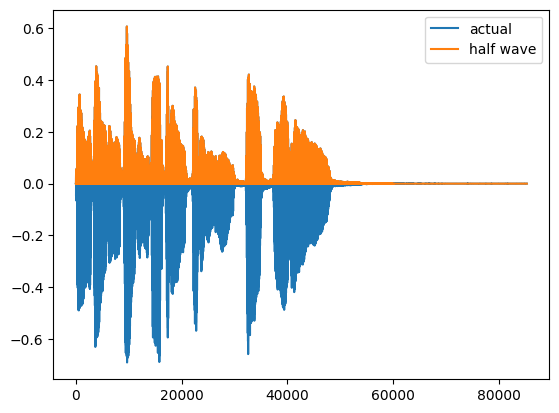

In [13]:
yd = y.copy()
yd[yd < 0] = 0
plt.plot(y, label='actual')
plt.plot(yd, label='half wave')
plt.legend()

In [14]:
Audio(yd, rate=sr)

Full wave rectifier

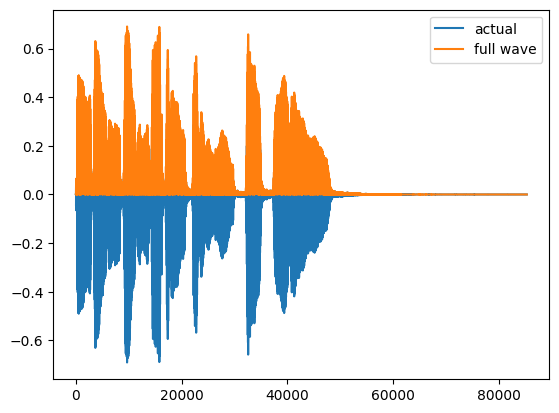

In [15]:
yd = y.copy()
yd = np.abs(yd)
plt.plot(y, label='actual')
plt.plot(yd, label='full wave')
plt.legend()

In [16]:
Audio(yd, rate=sr)

every odd sample zero

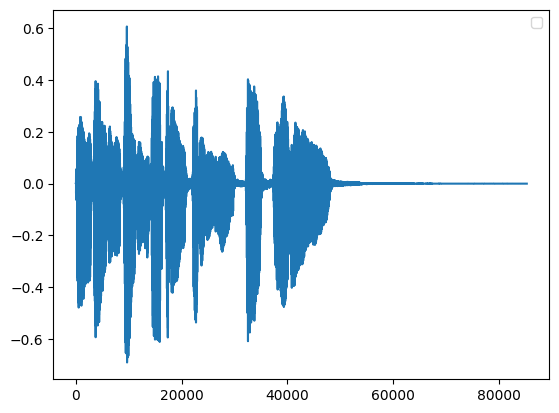

In [17]:
yd = y.copy()
yd[::2]=0
plt.plot(yd)
plt.legend()

In [18]:
Audio(yd, rate=sr)

rectangular pulse of width W

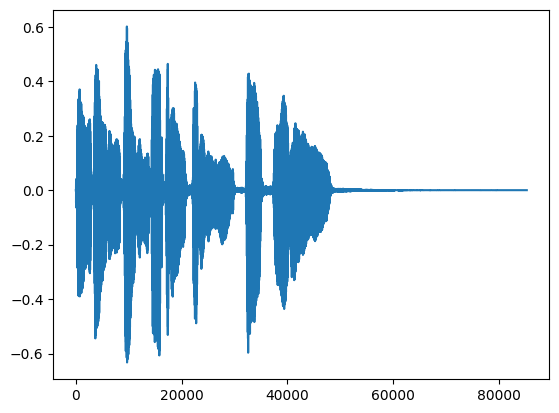

In [19]:
import scipy
b, a = scipy.signal.cheby2(N=5, rs=40, Wn=[500/(sr/2), 6000/(sr/2)], btype='bandpass')
yd = scipy.signal.filtfilt(b, a, y)
plt.plot(yd)

In [20]:
Audio(yd, rate=sr)



---

Silence removal (voice activity detection)

---



trim begin and end silence

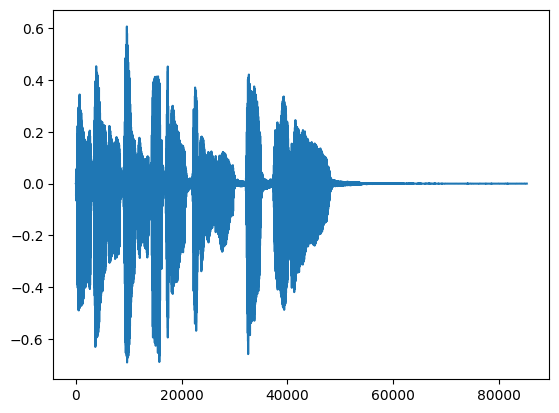

In [21]:
plt.plot(y)

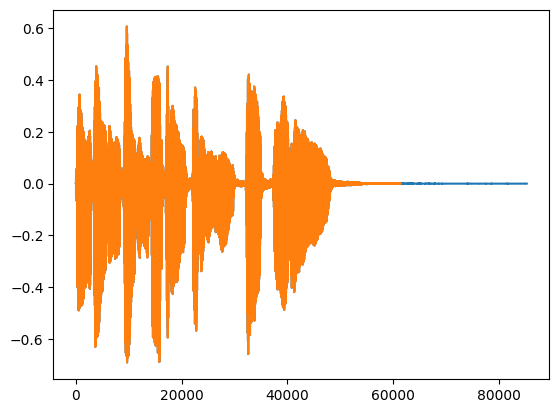

In [22]:
yd, _ = librosa.effects.trim(y)
plt.plot(y, label='original')
plt.plot(yd)

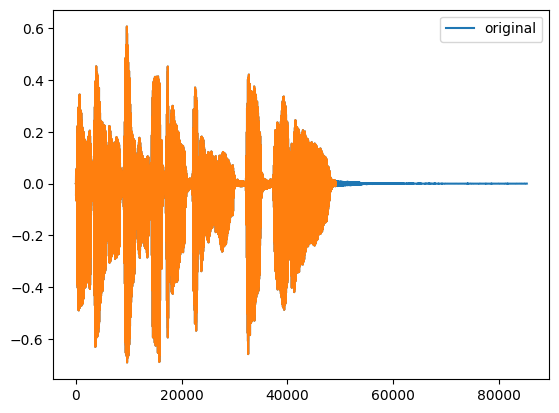

In [23]:
yd, _ = librosa.effects.trim(y, top_db=25)
plt.plot(y, label='original')
plt.plot(yd)
plt.legend()
plt.show()
Audio(yd, rate=sr)

[[    0 30720]
 [31744 36352]
 [36864 48640]]


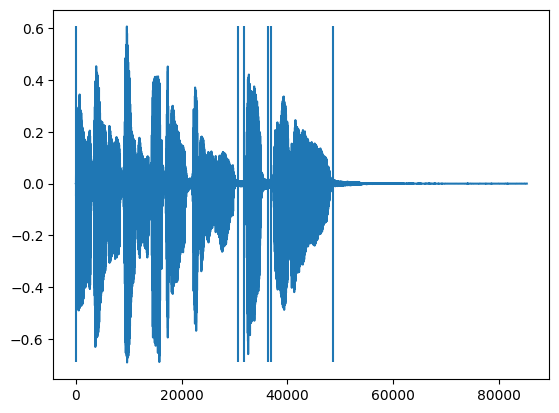

In [24]:
indices = librosa.effects.split(y, top_db=20)
print(indices)
plt.plot(y)
for i in indices:
    for idx in [0, -1]:
        plt.vlines(i[idx], min(y), max(y))



---



---


Augmentations

---



- time strech

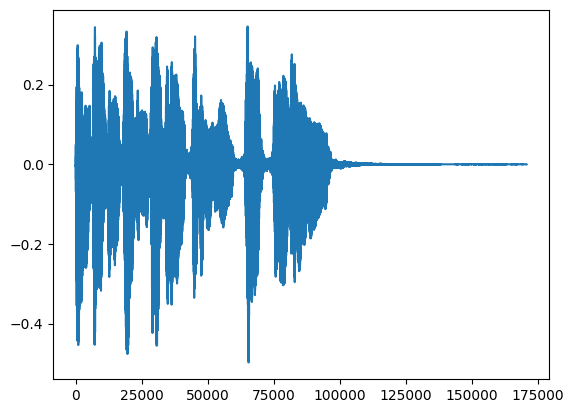

In [25]:
yd = librosa.effects.time_stretch(y, rate=0.5)
plt.plot(yd)
plt.show()
Audio(yd, rate=sr)

- picth shift

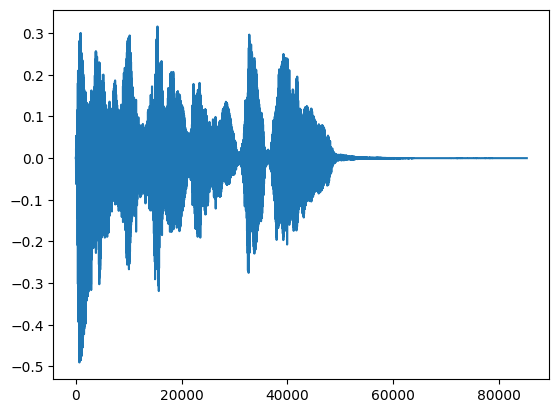

In [26]:
yd = librosa.effects.pitch_shift(y, sr=sr,  n_steps=-4)
plt.plot(yd)
plt.show()
Audio(yd, rate=sr)



---



---


Features

---



- stft

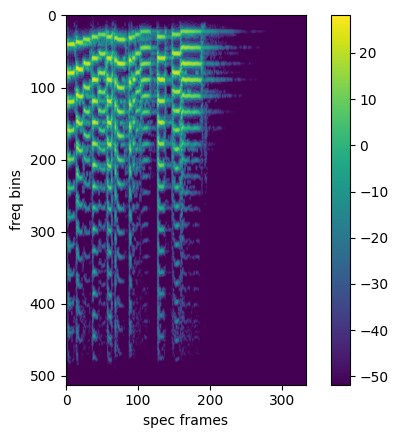

In [27]:
S = librosa.amplitude_to_db(np.abs(librosa.stft(y,
                                                n_fft=1024,
                                                hop_length=256,
                                                win_length=512
                                                )))
plt.imshow(S)
plt.ylabel("freq bins")
plt.xlabel("spec frames")
plt.colorbar();

- mel spectrogram

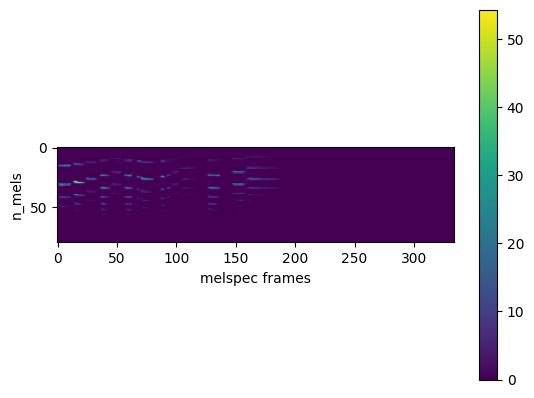

In [28]:
melspec = librosa.feature.melspectrogram(y=y,
                                         sr=sr,
                                         n_fft=1024,
                                         hop_length=256,
                                         win_length=1024,
                                         n_mels=80,
                                         )
plt.imshow(melspec)
plt.ylabel('n_mels')
plt.xlabel("melspec frames")
plt.colorbar();

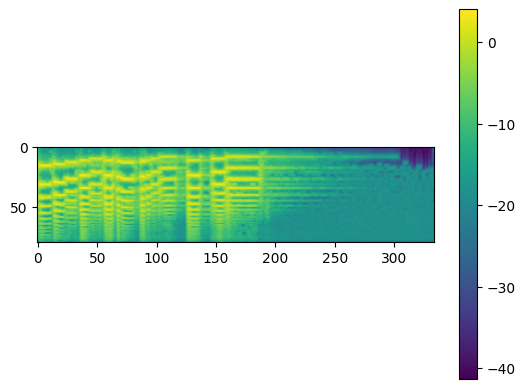

In [29]:
plt.imshow(np.log(melspec))
plt.colorbar()

- MFCC

<ipython-input-30-186143170f6d>:1: FutureWarning: Pass y=[-9.0889569e-04 -6.5751903e-04  1.1082299e-04 ... -9.8387054e-06
 -7.0730111e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=13, hop_length=256)


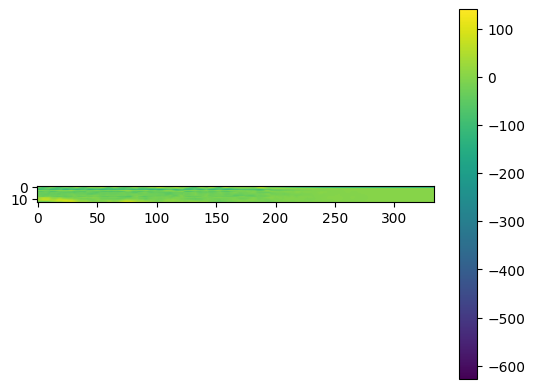

In [30]:
mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=13, hop_length=256)
plt.imshow(mfcc)
plt.colorbar()

<ipython-input-31-36996c6f442e>:1: FutureWarning: Pass y=[-9.0889569e-04 -6.5751903e-04  1.1082299e-04 ... -9.8387054e-06
 -7.0730111e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=13, hop_length=256)


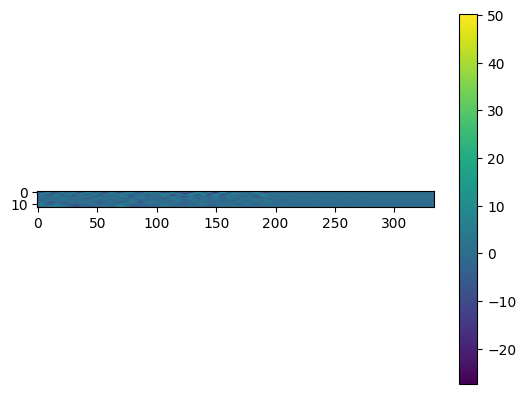

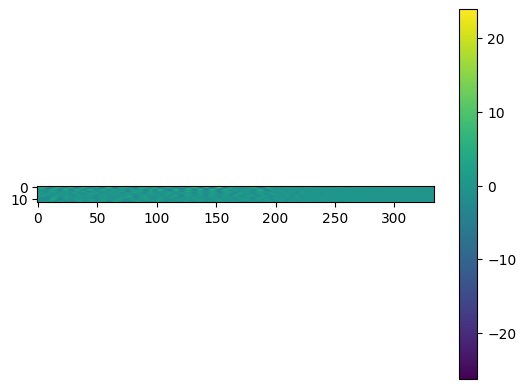

In [31]:
mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=13, hop_length=256)
delta = librosa.feature.delta(mfcc)
delta2 = librosa.feature.delta(mfcc, order=2)
plt.imshow(delta)
plt.colorbar()
plt.show()
plt.imshow(delta2)
plt.colorbar()

- tempogram

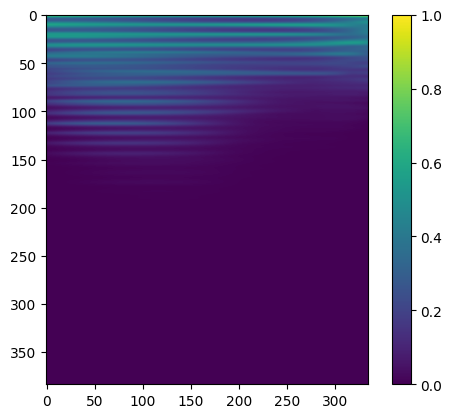

In [32]:
env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=256)
tempogram = librosa.feature.tempogram(onset_envelope=env,
                                    sr=sr,
                                    hop_length=256,
                                    )
plt.imshow(tempogram)
plt.colorbar();

- Fourier_tempogram

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=384 is too small for input signal of length=334
  return f(*args, **kwargs)


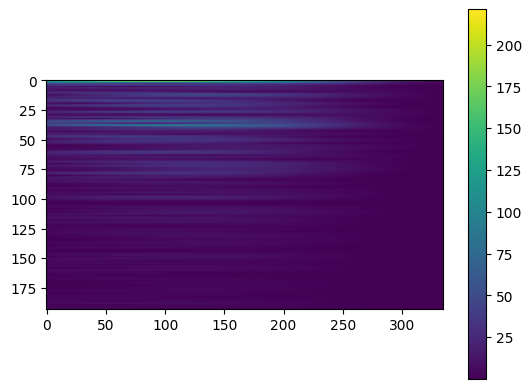

In [33]:
env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=256)
tempogram = np.abs(librosa.feature.fourier_tempogram(onset_envelope=env,
                                    sr=sr,
                                    hop_length=256,
                                    ))
plt.imshow(tempogram)
plt.colorbar();

filter banks

mel

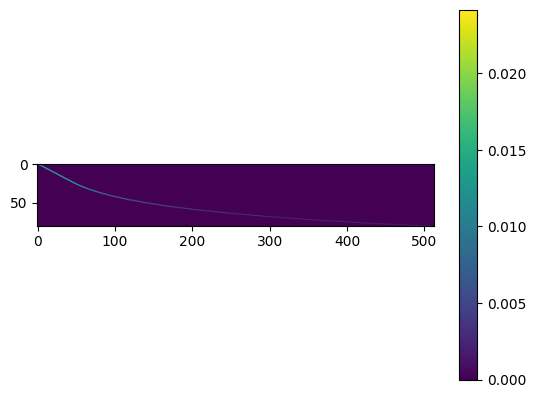

In [34]:
mel = librosa.filters.mel(sr=22050, n_fft=1024, n_mels=80)
plt.imshow(mel)
plt.colorbar()

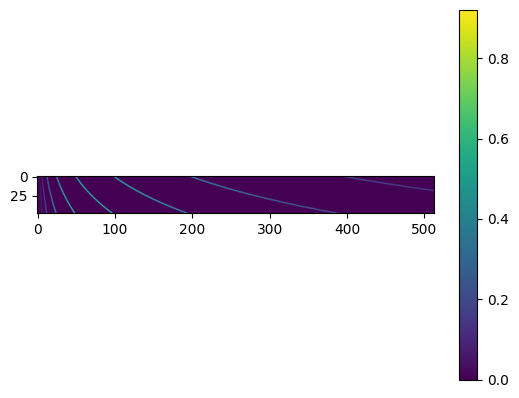

In [35]:
chroma = librosa.filters.chroma(sr=22050, n_fft=1024, n_chroma=48)
plt.imshow(chroma)
plt.colorbar()

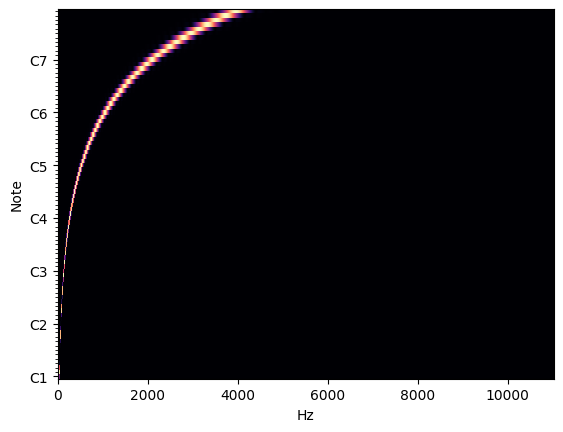

In [36]:
freqs = librosa.cqt_frequencies(n_bins=84, fmin=librosa.note_to_hz('C1'))
basis, lengths = librosa.filters.wavelet(freqs=freqs, sr=22050)
F = np.abs(np.fft.fftn(basis, axes=[-1]))
F = F[:, :(1 + F.shape[1] // 2)]
librosa.display.specshow(F, x_axis='linear', y_axis='cqt_note')



---



---


Additive noise on features

---



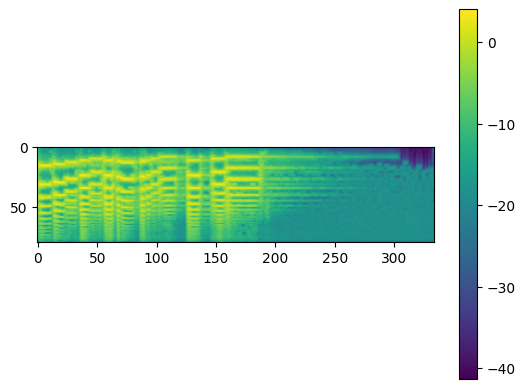

In [37]:
melspec = librosa.feature.melspectrogram(y=y,
                                         sr=sr,
                                         n_fft=1024,
                                         hop_length=256,
                                         win_length=1024,
                                         n_mels=80,
                                         )
plt.imshow(np.log(melspec))
plt.colorbar();

<ipython-input-38-ba055023b55b>:3: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(melspec_noisy))


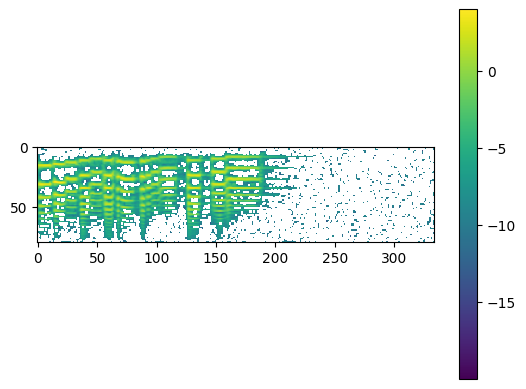

In [38]:
noise = np.random.normal(0, 1e-4, melspec.shape)
melspec_noisy = melspec + noise
plt.imshow(np.log(melspec_noisy))
plt.colorbar();

In [39]:
S = librosa.feature.inverse.mel_to_stft(melspec_noisy,
                                    sr=sr,
                                    n_fft=1024,
                                    )
audio = librosa.core.griffinlim(
                    S,
                    n_iter=32,
                    hop_length=256,
                    win_length=1024)
Audio(audio, rate=sr)

In [40]:
S = librosa.feature.inverse.mel_to_stft(melspec,
                                    sr=sr,
                                    n_fft=1024,
                                    )
audio = librosa.core.griffinlim(
                    S,
                    n_iter=32,
                    hop_length=256,
                    win_length=1024)
Audio(audio, rate=sr)






---


Additional resources


---



Speech enhancement with espnet toolkit -
https://espnet.github.io/espnet/notebook/espnet_se_demonstration_for_waspaa_2021.html

Voice conversion with espnet toolkit - https://github.com/espnet/espnet/tree/master/egs/arctic/vc1

voice style transfer - https://github.com/mazzzystar/randomCNN-voice-transfer

In [41]:
np.min(melspec_noisy), np.max(melspec_noisy)

(-0.00039783690417891657, 54.2703152991469)

In [42]:
np.min(melspec_noisy), np.max(melspec_noisy), np.min(melspec), np.max(melspec)


(-0.00039783690417891657, 54.2703152991469, 1.1186803e-18, 54.270332)